In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/EMG-data.csv')

In [8]:
from sklearn.model_selection import train_test_split

features = df.drop(columns=["label","class","time"])
Class = df["class"]
Class = Class.values
features = features.values
x_train, x_test, y_train, y_test = train_test_split(features, Class, test_size=0.2, random_state=1)


In [9]:
# Normalizing data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

In [10]:
# one hot encoding Labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [11]:
#plotter
def plot(loss,val_loss,acc,val_acc):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
    

In [14]:
from tensorflow.keras import layers, Sequential, optimizers, Input, Model

input_tensor = Input(shape=(8,))
x = layers.Dense(1024, activation='relu')(input_tensor)
y = layers.Dense(512, activation='relu')(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
z = layers.Dense(128, activation='relu')(y) # acyclic graghs of layers
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(8, activation='softmax')(z)

model = Model(input_tensor, output_tensor)

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
opt = optimizers.Nadam(learning_rate=1e-3)
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

#model.summary()

In [15]:
# saving model, creating log for tensorboaed and applying few callbacks

def callbacks(Log,Dir):
  import tensorflow as tf
  import os

  Filepath = Path
  logdir = os.path.join(Filepath, Dir)
  
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                 #  tensorboard log path      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # stop if not improving
                    monitor='val_accuracy',patience=2,),           # monitor validation accuracy
                    #tf.keras.callbacks.ReduceLROnPlateau(
                    #monitor='val_loss',factor=0.1,         # lr ko .1 se multiply kerdo (kam kerdo)
                    #patience=10,),                # reduce the lrate if val loss stop improving
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # save model path
                    monitor='val_loss',             # only save best weights
                    save_best_only=True,)]
  return callbacks_list

Epoch 1/200
5298/5298 [==============================] - 29s 5ms/step - loss: 0.9099 - accuracy: 0.6452 - val_loss: 0.8904 - val_accuracy: 0.6481
INFO:tensorflow:Assets written to: model1/assets
Epoch 2/200
5298/5298 [==============================] - 24s 5ms/step - loss: 0.8750 - accuracy: 0.6502 - val_loss: 0.8631 - val_accuracy: 0.6551
INFO:tensorflow:Assets written to: model1/assets
Epoch 3/200
5298/5298 [==============================] - 24s 5ms/step - loss: 0.8501 - accuracy: 0.6584 - val_loss: 0.8390 - val_accuracy: 0.6636
INFO:tensorflow:Assets written to: model1/assets
Epoch 4/200
5298/5298 [==============================] - 24s 5ms/step - loss: 0.8208 - accuracy: 0.6699 - val_loss: 0.8107 - val_accuracy: 0.6755
INFO:tensorflow:Assets written to: model1/assets
Epoch 5/200
5298/5298 [==============================] - 24s 5ms/step - loss: 0.7899 - accuracy: 0.6836 - val_loss: 0.7828 - val_accuracy: 0.6882
INFO:tensorflow:Assets written to: model1/assets
Epoch 6/200
5298/5298 [==

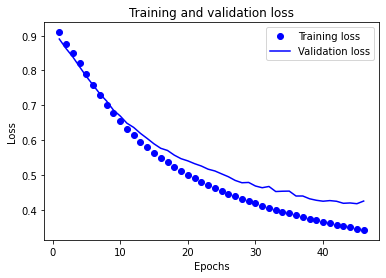

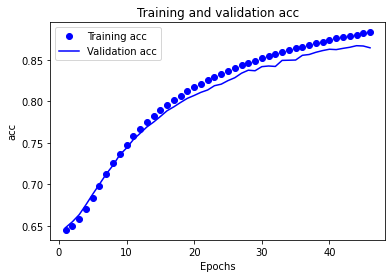

In [16]:
Path = "model1"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

batch_size = 512            
epochs = 200                

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2, callbacks=Call_B_Fun)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)


In [17]:
model.save('/content/drive/My Drive/model1/emg_1.h5')

In [19]:
# loading saved model
from tensorflow.keras.models import load_model
emg = '/content/drive/My Drive/model1/emg_1.h5'
emg_model = load_model(emg)
#emg_model.summary()

In [20]:
# Removing layers

new_model = Model(emg_model.inputs, emg_model.layers[-2].output) # removing layers
new_model.summary()
# removed all layers except conv

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              9216      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
Total params: 610,016
Trainable params: 610,016
Non-trainable params: 0
_____________________________________________________

In [22]:
from tensorflow.keras import layers, optimizers, Input, Model

input_tensor = Input(shape=(8,))
x = new_model(input_tensor)       # this is our old model
#z = layers.Dense(256, activation='relu')(x)
output_tensor = layers.Dense(8, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
opt = optimizers.Nadam(learning_rate=1e-3)
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
model_2 (Functional)         (None, 32)                610016    
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 264       
Total params: 610,280
Trainable params: 610,280
Non-trainable params: 0
_________________________________________________________________


In [23]:
def callbacks(Log,Dir):
  import tensorflow as tf
  import os

  Filepath = Path
  logdir = os.path.join(Filepath, Dir)
  
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                 #  tensorboard log path      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # stop if not improving
                    monitor='val_loss',patience=2,),           # monitor validation loss
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',factor=0.1,         # lr ko .1 se multiply kerdo (kam kerdo)
                    patience=10,),                # reduce the lrate if val loss stop improving
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # save model path
                    monitor='val_loss',             # only save best weights
                    save_best_only=True,)]
  return callbacks_list

Epoch 1/200
5298/5298 [==============================] - 24s 4ms/step - loss: 0.7263 - accuracy: 0.7400 - val_loss: 0.4733 - val_accuracy: 0.8350
INFO:tensorflow:Assets written to: model2/assets
Epoch 2/200
5298/5298 [==============================] - 23s 4ms/step - loss: 0.3805 - accuracy: 0.8650 - val_loss: 0.4225 - val_accuracy: 0.8620
INFO:tensorflow:Assets written to: model2/assets
Epoch 3/200
5298/5298 [==============================] - 23s 4ms/step - loss: 0.3533 - accuracy: 0.8775 - val_loss: 0.4130 - val_accuracy: 0.8683
INFO:tensorflow:Assets written to: model2/assets
Epoch 4/200
5298/5298 [==============================] - 23s 4ms/step - loss: 0.3407 - accuracy: 0.8830 - val_loss: 0.4152 - val_accuracy: 0.8681
Epoch 5/200
5298/5298 [==============================] - 23s 4ms/step - loss: 0.3340 - accuracy: 0.8857 - val_loss: 0.4077 - val_accuracy: 0.8716
INFO:tensorflow:Assets written to: model2/assets
Epoch 6/200
5298/5298 [==============================] - 23s 4ms/step - lo

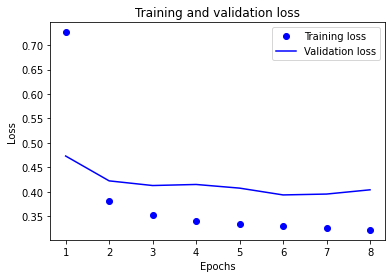

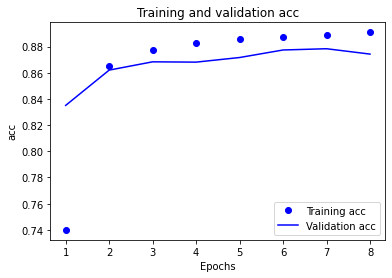

In [24]:
Path = "model2"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

batch_size = 512            
epochs = 200                

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2, callbacks=Call_B_Fun)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)

In [25]:
model.save('/content/drive/My Drive/model2/emg_2.h5')


In [26]:
# loading saved model
from tensorflow.keras.models import load_model
emg = '/content/drive/My Drive/model2/emg_2.h5'
emg_model = load_model(emg)
#emg_model.summary()

In [28]:
from tensorflow.keras import layers, Sequential, optimizers, Input, Model

input_tensor = Input(shape=(8,))
x = layers.Dense(1024, activation='relu')(input_tensor)
y = layers.Dense(512, activation='relu')(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
z = layers.Dense(128, activation='relu')(y) # acyclic graghs of layers
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(8, activation='softmax')(z)

model = Model(input_tensor, output_tensor)

opt = optimizers.Nadam(learning_rate=1e-3)
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.set_weights(emg_model.get_weights())   # using pretrained model weights

#model.summary()

In [30]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(   # stop if not improving
                monitor='val_accuracy',patience=5,),           # monitor validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                filepath='my_model.h5',
                monitor='val_loss',                   # only save best weights
                save_best_only=True,)]                # when vall loss is improved

batch_size = 512           
epochs = 15                

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2,
                    callbacks=callbacks_list)

Epoch 1/15
5298/5298 [==============================] - 23s 4ms/step - loss: 0.2809 - accuracy: 0.9073 - val_loss: 0.3597 - val_accuracy: 0.8951
Epoch 2/15
5298/5298 [==============================] - 22s 4ms/step - loss: 0.2788 - accuracy: 0.9081 - val_loss: 0.3591 - val_accuracy: 0.8968
Epoch 3/15
5298/5298 [==============================] - 22s 4ms/step - loss: 0.2769 - accuracy: 0.9091 - val_loss: 0.3541 - val_accuracy: 0.8984
Epoch 4/15
5298/5298 [==============================] - 23s 4ms/step - loss: 0.2749 - accuracy: 0.9097 - val_loss: 0.3668 - val_accuracy: 0.8946
Epoch 5/15
5298/5298 [==============================] - 23s 4ms/step - loss: 0.2721 - accuracy: 0.9107 - val_loss: 0.3616 - val_accuracy: 0.8973
Epoch 6/15
5298/5298 [==============================] - 22s 4ms/step - loss: 0.2710 - accuracy: 0.9110 - val_loss: 0.3562 - val_accuracy: 0.8984
Epoch 7/15
5298/5298 [==============================] - 22s 4ms/step - loss: 0.2684 - accuracy: 0.9120 - val_loss: 0.3540 - val_ac

In [31]:
model.save('/content/drive/My Drive/model2/emg_3.h5')


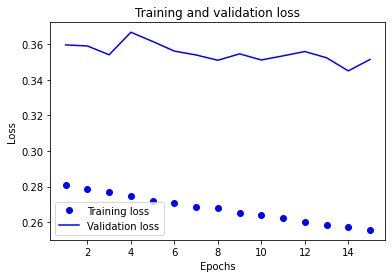

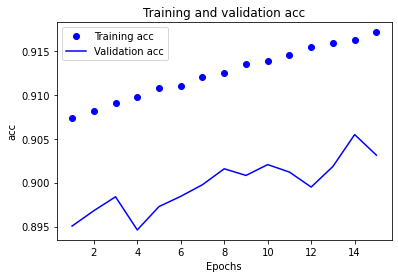

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)

In [33]:
evaluation = model.evaluate(x_test,  y_test,batch_size=batch_size, verbose=2)
print()
print("Test loss :",evaluation[0]*100,"%")
print("Test accuracy :",evaluation[1]*100,"%")

1656/1656 - 3s - loss: 0.3508 - accuracy: 0.9038

Test loss : 35.082295536994934 %
Test accuracy : 90.37615060806274 %


In [35]:
predict = 1002
a = np.argmax(model.predict(x_test)[predict])
print("Predicted Class: ",a)
print("Actual Class: ",np.argmax(y_test[predict]))

Predicted Class:  0
Actual Class:  0
